# Load Data

In [1]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 14.8 MB/s 
     |████████████████████████████████| 132 kB 70.9 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 10.2 MB 65.2 MB/s 
     |████████████████████████████████| 140 kB 16.4 MB/s 
     |████████████████████████████████| 127 kB 13.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 13.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag
from utils import TAG2IDX, IDX2TAG, DATA_DIR, WSJ_DIR, MODEL_DIR, RESULT_DIR, PLOT_TAGS_DIR
from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


100%|██████████| 213450/213450 [00:00<00:00, 879512.45B/s]


In [3]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

100%|██████████| 404400730/404400730 [00:14<00:00, 27256976.98B/s]


In [4]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [5]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

model_file = os.path.join(MODEL_DIR, "base_model.pt")
model.load_state_dict(torch.load(model_file))
wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value = eval(model, test_iter, save_output=False)
print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)


tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)


# Self Training

In [6]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [7]:
domain = "newsgroups"
domain_dir = os.path.join(DATA_DIR, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [8]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 1196
The number of tags 49
The number of samples: 1195
The number of tags 49
after filter tag 1190
after filter tag 1180


In [9]:
# create dir
sub_result_dir = os.path.join(RESULT_DIR, "Online_fixed_self_learning", domain)
if not os.path.isdir(sub_result_dir):
  os.makedirs(sub_result_dir)
  print("Create", sub_result_dir)

sub_plots_tags_dir = os.path.join(PLOT_TAGS_DIR, "Online_fixed_self_learning", domain)
if not os.path.isdir(sub_plots_tags_dir):
  os.makedirs(sub_plots_tags_dir)
  print("Create", sub_plots_tags_dir)

In [10]:
class PosDataset_new(data.Dataset):
    def __init__(self, word_lst, tag_lst):
        self.word_lst, self.tag_lst = word_lst, tag_lst

    def __len__(self):
      return len(self.word_lst)

    def __getitem__(self, idx):
      words, tags = self.word_lst[idx], self.tag_lst[idx] # words, tags: string list
      assert len(words)==len(tags)
        # seqlen
      seqlen = len(words)

      return words, tags, seqlen

def pad_new(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    tags = f(1)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(0, maxlen)
    y = f(1, maxlen)

    f = torch.LongTensor

    return f(x), f(y), seqlens

def train_new(model, iterator, optimizer, criterion):
    model.train()
    for i, batch in enumerate(iterator):
        x, y, seqlens = batch
        
        optimizer.zero_grad()
        logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)

        logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))


def gen_pseudo_data(model, domain_dev_iter, topn=300, initial=True, device=DEVICE, num_classes=len(TAG2IDX)):
  model.eval()

  LLD = []
  MEAN_PROB = []
  new_x_lst = []
  new_y_lst = []
  acc_lst = []

  if initial:
    with torch.no_grad():
        for i, batch in enumerate(domain_dev_iter):

          _, x, _, _, y, _ = batch
          # When calculating the length of sentences, ignore <pad>
          sen_len = y.bool().sum(axis=1)

          logits, _, y_hat = model(x, y)  # y_hat: (N, T)

          # Save prediction as new training dataset
          softmax_value = torch.softmax(logits, dim=2)
          max_prob = torch.amax(softmax_value, dim=2)

          # Rank by mean probability
          res_prob = y.bool().to(device) * max_prob.to(device)
          sum_prob = res_prob.sum(axis=1)
          mean_prob = sum_prob / sen_len.to(device)
          MEAN_PROB.extend(mean_prob.tolist())
          
          new_x_lst.extend(x.tolist())
          new_y_lst.extend(y_hat.tolist())

          # Calculate the accuracy for each sentences, ignore 0
          batch_acc = multiclass_accuracy(
              torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes, 
              ignore_index=0, average="micro", multidim_average="samplewise")
          acc_lst.extend(batch_acc.tolist())
          

  else:
    with torch.no_grad():
        for i, batch in enumerate(domain_dev_iter):

          x, y, seqlens = batch
          sen_len = y.bool().sum(axis=1)

          logits, _, y_hat = model(x, y)  # y_hat: (N, T)

          # Save prediction as new training dataset
          softmax_value = torch.softmax(logits, dim=2)
          max_prob = torch.amax(softmax_value, dim=2)

          # Rank by mean probability
          res_prob = y.bool().to(device) * max_prob.to(device)
          sum_prob = res_prob.sum(axis=1)
          mean_prob = sum_prob / sen_len.to(device)
          MEAN_PROB.extend(mean_prob.tolist())
          
          new_x_lst.extend(x.tolist())
          new_y_lst.extend(y_hat.tolist())

          # Calculate the accuracy for each sentences, ignore 0
          batch_acc = multiclass_accuracy(
              torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes, 
              ignore_index=0, average="micro", multidim_average="samplewise")
          acc_lst.extend(batch_acc.tolist())

  ind = list(range(len(MEAN_PROB)))
  ind = [x for _, x in sorted(zip(MEAN_PROB, ind), reverse=True)]
  prob_lst = [prob for prob, _ in sorted(zip(MEAN_PROB, ind), reverse=True)]

  select_ind = ind[: topn] # The index of topn sentences
  not_select_ind = ind[topn: ]

  new_train_x = [new_x_lst[i] for i in select_ind]
  new_train_y = [new_y_lst[i] for i in select_ind]

  remain_train_x = [new_x_lst[i] for i in not_select_ind]
  remain_train_y = [new_y_lst[i] for i in not_select_ind]

  new_prob = prob_lst[: topn]
  remain_prob = prob_lst[topn: ]
  new_acc = [acc_lst[i] for i in select_ind]
  remain_acc = [acc_lst[i] for i in not_select_ind]


  return new_train_x, new_train_y, remain_train_x, remain_train_y, new_acc, remain_acc, new_prob, remain_prob

In [11]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

In [12]:
loop_i = 0
top_percent = 0.1

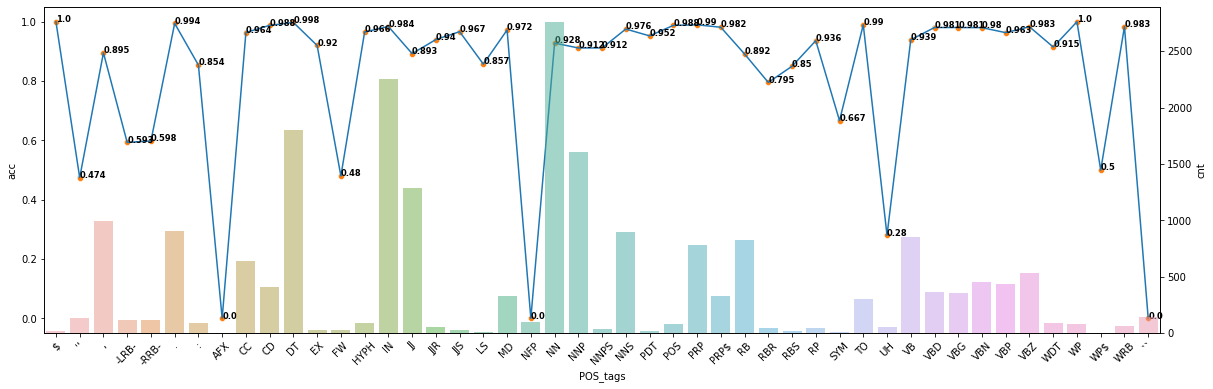

In [13]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"{top_percent}-loop{loop_i}.txt")
domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)


In [14]:
acc_lst = []
prob_lst = []

topn = int(top_percent * len(domain_dev_word_lst))

while len(domain_dev_word_lst) >= topn:
  loop_i += 1
  print("\nLoop", loop_i)
  print("domain_dev_word_lst", len(domain_dev_word_lst))

  if loop_i == 1:
    domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

    domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                                batch_size=8,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)
  else:
    domain_dev_dataset = PosDataset_new(domain_dev_word_lst, domain_dev_tag_lst)

    domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                                batch_size=8,
                                shuffle=True,
                                num_workers=1,
                                collate_fn=pad_new)
    
  initial = True if loop_i==1 else False
  new_train_x, new_train_y, domain_dev_word_lst, domain_dev_tag_lst, new_acc, remain_acc, new_prob, remain_prob = gen_pseudo_data(model, domain_dev_iter, topn, initial)

  new_train_dataset = PosDataset_new(new_train_x, new_train_y)

  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad_new)

  optimizer = optim.Adam(model.parameters(), lr = 0.00001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train_new(model, new_train_iter, optimizer, criterion)

  output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}.txt")
  # domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)
  domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value = eval(model, domain_test_iter, save_output=False)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  acc_lst.append(new_acc)
  prob_lst.append(new_prob)

  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
  # _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)
  _ = analysis_output(output_res_file, csvsave=False, pngsave=False)



Loop 1
domain_dev_word_lst 1190


<ipython-input-10-65382ea07f4b>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.4525087773799896
step: 10, loss: 0.01140894927084446

Loop 2
domain_dev_word_lst 1071


<ipython-input-10-65382ea07f4b>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.005729755852371454
step: 10, loss: 0.001925275195389986

Loop 3
domain_dev_word_lst 952
step: 0, loss: 0.002757290843874216
step: 10, loss: 0.001721417298540473

Loop 4
domain_dev_word_lst 833
step: 0, loss: 0.00402934430167079
step: 10, loss: 0.00809317734092474

Loop 5
domain_dev_word_lst 714
step: 0, loss: 0.007389171048998833
step: 10, loss: 0.0034812134690582752

Loop 6
domain_dev_word_lst 595
step: 0, loss: 0.004704133607447147
step: 10, loss: 0.004594121593981981

Loop 7
domain_dev_word_lst 476
step: 0, loss: 0.007472809869796038
step: 10, loss: 0.005071318708360195

Loop 8
domain_dev_word_lst 357
step: 0, loss: 0.010176843963563442
step: 10, loss: 0.008641568943858147

Loop 9
domain_dev_word_lst 238
step: 0, loss: 0.018579043447971344
step: 10, loss: 0.014219297096133232

Loop 10
domain_dev_word_lst 119
step: 0, loss: 0.02909177355468273
step: 10, loss: 0.04583516716957092


In [15]:
# acc_df = pd.DataFrame()
# for i in range(len(acc_lst)):
#   acc_df[f"Loop{i}"] = acc_lst[i]

# prob_df = pd.DataFrame()
# for i in range(len(prob_lst)):
#   prob_df[f"Loop{i}"] = prob_lst[i]

In [16]:
# print(domain_precision_value_lst)
# print(domain_recall_value_lst)
# print(domain_f1_value_lst)
# print(domain_acc_value_lst)

# print(acc_lst)
# print(prob_lst)

In [17]:
import pandas as pd

In [18]:
test_metric = pd.DataFrame({
    "Loop": list(range(len(domain_precision_value_lst))) * 3,
    "metric": ["precision"]*len(domain_precision_value_lst) + ["recall"]*len(domain_precision_value_lst) + ["f1"]*len(domain_precision_value_lst),
    "value": domain_precision_value_lst + domain_recall_value_lst + domain_f1_value_lst
})

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [21]:
fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
fig.show()